<div style="background-image:url(images/meschede-seismic-waves.png); padding: 10px 30px 20px 30px; background-size:cover; background-opacity:50%; border-radius:5px">
<p style="float:right; margin-top:20px; padding: 20px 20px 0px 20px; background:rgba(255,255,255,0.6); border-radius:10px;">
<img width="400px" src=images/obspy_logo_full_524x179px.png?raw=true>

</p>

<h1 style="color:#999">Geophysical Data Analysis</h1>
<h5 style="color:#FFF">LMU, July 2015</h5>
<br/>
<h2 style="color:#EEE">Python and ObsPy Introduction</h2>
<br/>

</div>
<div align="right">image by Matthias Meschede</div>

Again, please execute the following cell, it contains a few adjustments to the notebook.

In [1]:
%pylab inline
from __future__ import print_function
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

Populating the interactive namespace from numpy and matplotlib


 # B) ObsPy Introduction

In this *very* short introduction to ObsPy we will see how we can start from scratch to acquire time series data (aka waveforms) of the ground shaking resulting from earthquakes, recorded at seismometer stations. Many global seismometer recordings are free to be downloaded by everybody. We will also see how these data can be handled in Python using the ObsPy framework.

We will:
 * a) fetch information on earthquakes (aka events) hosted by international data centers
 * b) fetch information on seismometer stations that recorded a particular earthquake
 * c) fetch waveform data of the earthquake waves recorded at that station
 * d) convert the raw recorded data to physical units (aka instrument correction)
 
### a) Event Metadata

 * several different protocols are implemented in ObsPy to connect to all important seismological data centers
 * the most important protocol are [FDSN web services](http://docs.obspy.org/packages/obspy.fdsn.html) (other protocols work very similar)
 * the "[`get_events()`](http://docs.obspy.org/packages/autogen/obspy.fdsn.client.Client.get_events.html)" method has many ways to restrict the search results (time, geographic, magnitude, ..)

3 Event(s) in Catalog:
2012-04-11T08:38:37.800000Z |  +2.238,  +93.014 | 8.6 MW
2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1 MW
2010-02-27T06:34:13.330000Z | -36.148,  -72.933 | 8.8 MW


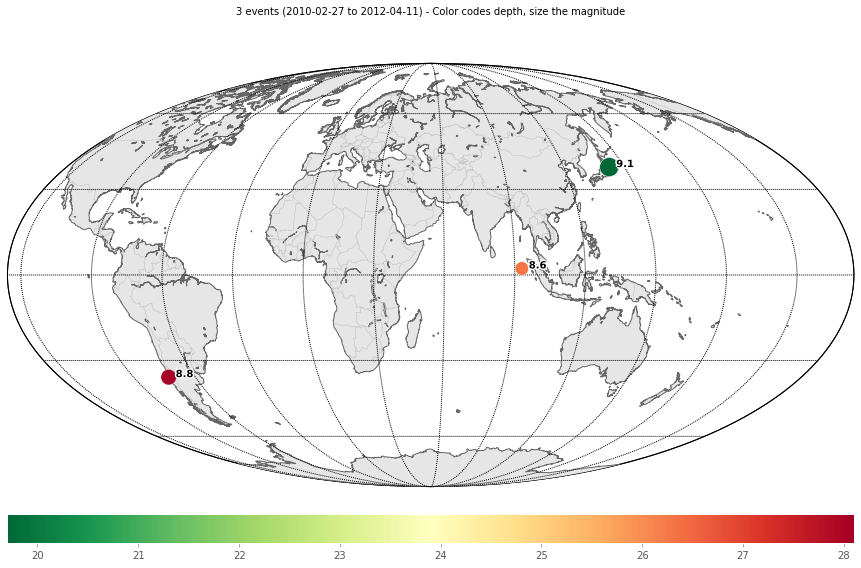

In [2]:
from obspy.fdsn import Client

# IRIS is the biggest seismological data center, based in the US
client_iris = Client("IRIS")

catalog = client_iris.get_events(minmagnitude=8.5, starttime="2010-01-01")

print(catalog)
catalog.plot();

- event/earthquake metadata is bundled in a **`Catalog`** object, which is a collection (~list) of **`Event`** objects
- `Event` objects are again collections of other resources (origins, magnitudes, picks, ...)
- the nested ObsPy Event class structure (Catalog/Event/Origin/Magnitude/FocalMechanism/...) is closely modelled after [QuakeML](https://quake.ethz.ch/quakeml) (the international standard exchange format for event metadata)
<img src="images/Event.svg" width=100%>
<img src="images/quakeml_light.png" width=100%>

In [3]:
print(catalog)

3 Event(s) in Catalog:
2012-04-11T08:38:37.800000Z |  +2.238,  +93.014 | 8.6 MW
2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1 MW
2010-02-27T06:34:13.330000Z | -36.148,  -72.933 | 8.8 MW


In [4]:
event = catalog[1]
print(event)

Event:	2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1 MW

	        resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=3279407")
	         event_type: u'earthquake'
	---------
	 event_descriptions: 1 Elements
	            origins: 1 Elements
	         magnitudes: 1 Elements


In [5]:
t = event.origins[0].time
print(t)

2011-03-11T05:46:23.200000Z


In [6]:
# you can use Tab-Completion to see what attributes/methods the event object has:
event.
origin.

SyntaxError: invalid syntax (<ipython-input-6-7757108bfa95>, line 2)

### b) Station Metadata

 * again, several different protocols are implemented in ObsPy to connect to all important seismological data centers
 * the most important protocol are [FDSN web services](http://docs.obspy.org/packages/obspy.fdsn.html) (other protocols work similar)
 * the "[`get_stations()`](http://docs.obspy.org/packages/autogen/obspy.fdsn.client.Client.get_stations.html)" method has many ways to restrict the search results (time, geographic, station names, ..)

Inventory created at 2015-07-27T11:20:38.000000Z
	Sending institution: SeisComP3 (BGR)
	Contains:
		Networks (2):
			GR
			OE
		Stations (8):
			GR.FUR (GRSN Station Fuerstenfeldbruck)
			GR.GRB5 (Graefenberg Array Station Vorderoedberg)
			GR.GRC1 (Graefenberg Array Station Amtmannsdorf)
			GR.GRC2 (Graefenberg Array Station Boehmfeld)
			GR.GRC3 (Graefenberg Array Station Steinsdorf)
			GR.GRC4 (Graefenberg Array Station Raitenbuch)
			OE.RETA (REUTTE, AUSTRIA)
			OE.WTTA (WATTENBERG, AUSTRIA)
		Channels (0):



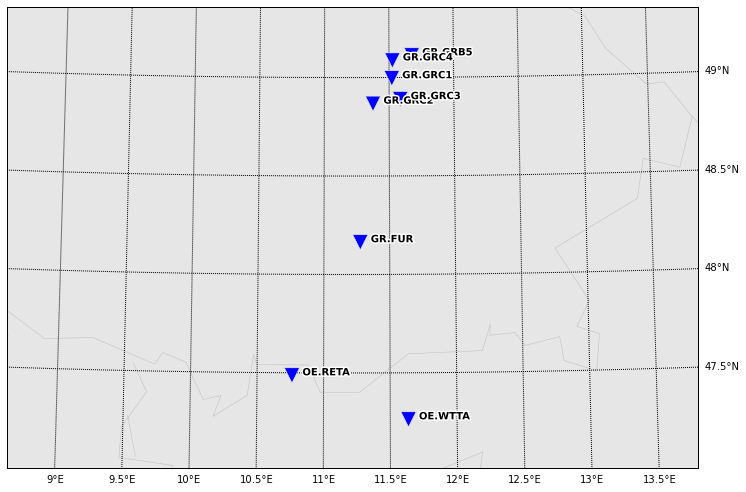

In [7]:
# BGR in Hanover is bundling data from the German Regional Seismic Network (GRSN)
client_bgr = Client("BGR")

muc_longitude = 11.58
muc_latitude = 48.13

inventory = client_bgr.get_stations(
    starttime=t, endtime=t+10,
    longitude=muc_longitude, latitude=muc_latitude, maxradius=1,
    channel="BHZ")

print(inventory)
inventory.plot(projection="local");

- station metadata is bundled in an **`Inventory`** object, which is a collection (~list) of **`Network`** objects, ...
- the nested ObsPy Inventory class structure (Inventory/Network/Station/Channel/Response/...) is closely modelled after [FDSN StationXML](http://www.fdsn.org/xml/station/) (the international standard exchange format for station metadata)
- `Network` objects are again collections of `Station` objects, which are collections of `Channel` objects

<img src="images/Inventory.svg" width=100%>
<img src="images/stationxml_light.png" width=100%>

In [8]:
# let's request metadata for one particular station,
# GRSN station "FUR" at the Geophysical Observatory in Fuerstenfeldbruck
inventory = client_bgr.get_stations(network="GR", station="FUR", level="response")
# when searching for many available stations response information is not included by default,
# because of the huge size. we explicitly need to specify that we want response information included
print(inventory)

Inventory created at 2015-07-27T11:20:46.000000Z
	Sending institution: SeisComP3 (BGR)
	Contains:
		Networks (1):
			GR
		Stations (1):
			GR.FUR (GRSN Station Fuerstenfeldbruck)
		Channels (18):
			GR.FUR..BHE, GR.FUR..BHE, GR.FUR..BHN, GR.FUR..BHN, GR.FUR..BHZ,
			GR.FUR..BHZ, GR.FUR..HHE, GR.FUR..HHE, GR.FUR..HHN, GR.FUR..HHN,
			GR.FUR..HHZ, GR.FUR..HHZ, GR.FUR..LHE, GR.FUR..LHE, GR.FUR..LHN,
			GR.FUR..LHN, GR.FUR..LHZ, GR.FUR..LHZ


In [9]:
network = inventory[0]
print(network)

Network GR (German Regional Seismic Network, BGR Hannover)
	Station Count: None/None (Selected/Total)
	1976-02-17T00:00:00.000000Z - --
	Access: open
	Contains:
		Stations (1):
			GR.FUR (GRSN Station Fuerstenfeldbruck)
		Channels (18):
			GR.FUR..BHE, GR.FUR..BHE, GR.FUR..BHN, GR.FUR..BHN, GR.FUR..BHZ,
			GR.FUR..BHZ, GR.FUR..HHE, GR.FUR..HHE, GR.FUR..HHN, GR.FUR..HHN,
			GR.FUR..HHZ, GR.FUR..HHZ, GR.FUR..LHE, GR.FUR..LHE, GR.FUR..LHN,
			GR.FUR..LHN, GR.FUR..LHZ, GR.FUR..LHZ


In [10]:
station = network[0]
print(station)

Station FUR (GRSN Station Fuerstenfeldbruck)
	Station Code: FUR
	Channel Count: None/None (Selected/Total)
	1991-03-01T00:00:00.000000Z - 
	Access: open 
	Latitude: 48.16, Longitude: 11.28, Elevation: 565.0 m
	Available Channels:
		FUR..BHE, FUR..BHE, FUR..BHN, FUR..BHN, FUR..BHZ, FUR..BHZ,
		FUR..HHE, FUR..HHE, FUR..HHN, FUR..HHN, FUR..HHZ, FUR..HHZ,
		FUR..LHE, FUR..LHE, FUR..LHN, FUR..LHN, FUR..LHZ, FUR..LHZ


In [11]:
channel = station[0]
print(channel)
print(channel.response)

Channel 'BHE', Location '' 
	Time range: 1991-03-01T00:00:00.000000Z - 2006-12-21T00:00:00.000000Z
	Latitude: 48.16, Longitude: 11.28, Elevation: 565.0 m, Local Depth: 0.0 m
	Azimuth: 90.00 degrees from north, clockwise
	Dip: 0.00 degrees down from horizontal
	Sampling Rate: 20.00 Hz
	Sensor: None
	Response information available
Channel Response
	From m/s () to COUNTS ()
	Overall Sensitivity: 5.98802e+08 defined at 1.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 5.98802e+08
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 1


In [12]:
# you can use Tab-Completion to see what attributes/methods the inventory object has:
inventory.
channel.

SyntaxError: invalid syntax (<ipython-input-12-53cf0f316be4>, line 2)

### c) Waveform Data (seismometer time series)

 * again, several different protocols are implemented in ObsPy to connect to all important seismological data centers
 * also, local files in all important exchange formats can be read
 * the most important protocol are [FDSN web services](http://docs.obspy.org/packages/obspy.fdsn.html) (other protocols work similar)
 * the "[`get_waveforms()`](http://docs.obspy.org/packages/autogen/obspy.fdsn.client.Client.get_waveforms.html)" method needs the unique identification of the station (network, station, location and channel codes) and a time range (start time, end time) of requested data

3 Trace(s) in Stream:
GR.FUR..BHE | 2011-03-11T05:56:19.839999Z - 2011-03-11T06:56:26.439999Z | 20.0 Hz, 72133 samples
GR.FUR..BHN | 2011-03-11T05:56:14.889999Z - 2011-03-11T06:56:32.839999Z | 20.0 Hz, 72360 samples
GR.FUR..BHZ | 2011-03-11T05:56:22.539999Z - 2011-03-11T06:56:30.689999Z | 20.0 Hz, 72164 samples


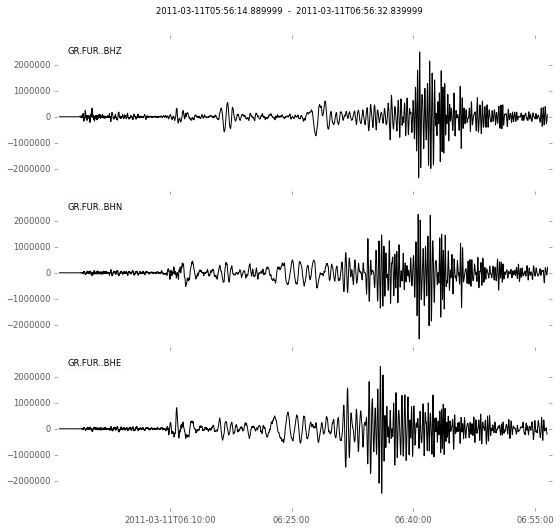

In [13]:
stream = client_bgr.get_waveforms(network="GR", station="FUR",
                                  location="*", channel="BH*",
                                  starttime=t+10*60, endtime=t+70*60)
# for functions/methods that need a fixed set of parameters,
# we usually omit the parameter names and specify them in the expected order
# Note that new timestamp objects can be created by
# adding/subtracting seconds to/from an existing timestamp object.
# (for details search the ObsPy documentation pages for "UTCDateTime")
stream = client_bgr.get_waveforms("GR", "FUR", "*", "BH*", t+10*60, t+70*60)
print(stream)
stream.plot()

the nested ObsPy Inventory class structure (Inventory/Station/Channel/Response/...) is closely modelled after [FDSN StationXML](http://www.fdsn.org/xml/station/) (the international standard exchange format for station metadata)

- waveform data is bundled in a **`Stream`** object, which is a collection (~list) of **`Trace`** objects
- **`Trace`** objects consist of one single, contiguous waveform data block (i.e. regularly spaced time series, no gaps)
- **`Trace`** objects consist of two attributes:
  - **`trace.data`** (the raw time series as an [**`numpy.ndarray`**](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html)) and..
  - **`trace.stats`** (metainformation needed to interpret the raw sample data)

<img src="images/Stream_Trace.svg" width=90%>

In [14]:
trace = stream[0]
# trace.data is the numpy array with the raw samples
print(trace.data)
print(trace.data[20:30])
# arithmetic operations on the data
print(trace.data[20:30] / 223.5)
# using attached numpy methods
print(trace.data.mean())
# pointers to the array in memory can be passed to C/Fortran routines from inside Python!

[    236     394     394 ..., -206205 -207449 -208858]
[-215 -337 -324 -398 -448 -562 -608 -571 -490 -410]
[-0.96196868 -1.50782998 -1.44966443 -1.78076063 -2.00447427 -2.51454139
 -2.72035794 -2.55480984 -2.19239374 -1.8344519 ]
-463.822550012


In [15]:
# trace.stats contains the basic metadata identifying the trace
print(trace)
print(trace.stats)
print(trace.stats.sampling_rate)

GR.FUR..BHE | 2011-03-11T05:56:19.839999Z - 2011-03-11T06:56:26.439999Z | 20.0 Hz, 72133 samples
         network: GR
         station: FUR
        location: 
         channel: BHE
       starttime: 2011-03-11T05:56:19.839999Z
         endtime: 2011-03-11T06:56:26.439999Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 72133
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'record_length': 512, 'encoding': u'STEIM2', 'filesize': 525312, u'dataquality': u'D', 'number_of_records': 1026, 'byteorder': u'>'})
20.0


In [16]:
# many convenience routines are attahed to Stream/Trace, use Tab completion
stream.

SyntaxError: invalid syntax (<ipython-input-16-b69bbcafc322>, line 2)

### d) Converting raw seismometer recordings to physical units (aka instrument correction)

 * for this we need to combine the raw waveform data of the recording system (seismometer, digitizer) with the metadata on its amplitude and phase response (the instrument response)
 * these information are kept separate for various practical and technical reasons (space in storage and streaming, correcting of errors made in the metadata, ...)

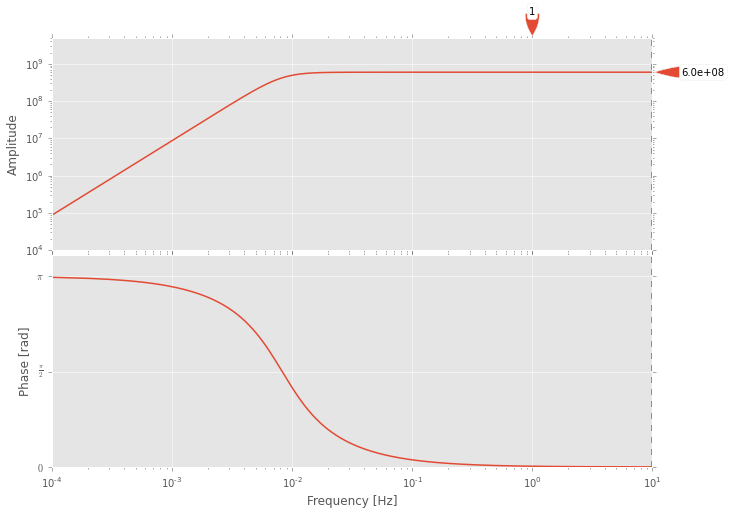

In [18]:
# first, let's have a look at this channel's instrument response
channel.plot(min_freq=1e-4);

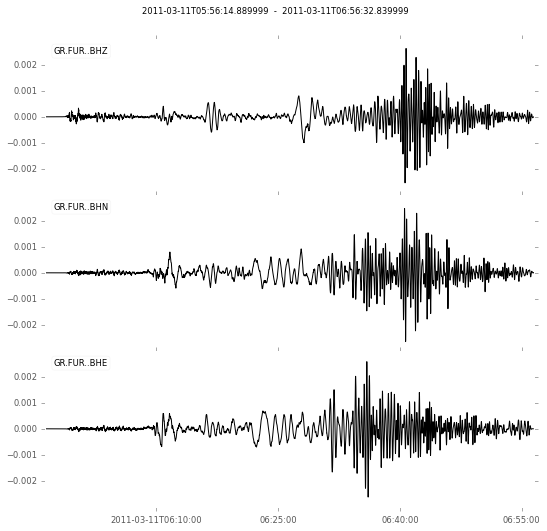

In [19]:
# we already have fetched the station metadata,
# including every piece of information down to the instrument response

# attach the instrument response to the waveforms..
stream.attach_response(inventory)
# and convert the data to ground velocity in m/s,
# taking into account the specifics of the recording system
stream.remove_response(water_level=10, output="VEL")
stream.plot()

### ObsPy has much more functionality, check it out on the ObsPy documentation pages at http://docs.obspy.org.

 * many, many convenience routines attached to `Stream`/`Trace`, `Catalog`/`Event`/.., `Inventory`/... for easy manipulation
 * filtering, detrending, demeaning, rotating, resampling, ...
 * array analysis, cross correlation routines, event detection, ...
 * estimate travel times and [plot ray paths](http://docs.obspy.org/tutorial/code_snippets/travel_time.html#body-wave-ray-paths) of seismic phases for specified source/receiver combinations
 * ...
 
 <img src="images/taup.png" width=80%>
 
 ---

## Exercise

Problems? Questions?

 - [ObsPy Documentation](http://docs.obspy.org/) (use the search)
 - Use IPython tab completion
 - Use interactive IPython help (e.g. after import type: `readEvents?`)
 - **Ask!**
 
a) Read the event metadata from local file "`./data/events_unterhaching.xml`" using the [`readEvents(filename)`](http://docs.obspy.org/packages/autogen/obspy.core.event.readEvents.html) function. Print the catalog summary.

In [20]:
from obspy import readEvents
catalog = readEvents("./data/events_unterhaching.xml")
print(catalog)

7 Event(s) in Catalog:
2010-05-27T16:24:31.802036Z | +48.048,  +11.646 | 2.08662460284 Ml
2010-05-27T16:43:49.542034Z | +48.048,  +11.646 | 1.4954033383 Ml
2013-04-16T21:51:42.648944Z | +48.046,  +11.643 | 1.96765657554 Ml
2013-04-16T21:51:47.556942Z | +48.045,  +11.643 | 1.88540591771 Ml
2013-04-16T22:00:01.861996Z | +48.047,  +11.643 | 1.31056358704 Ml
2013-04-16T22:15:28.557771Z | +48.046,  +11.643 | 1.76859128731 Ml
2013-04-18T18:15:57.733615Z | +48.045,  +11.642 | 1.57623047808 Ml


b) Take one event out of the catalog. Print its summary. You can see there is information included on picks set for the event. Print the information of at least one pick that is included in the event metadata. We now know one station that recorded the event.

In [21]:
event = catalog[0]
print(event)
print(event.picks[0])

Event:	2010-05-27T16:24:31.802036Z | +48.048,  +11.646 | 2.08662460284 Ml

	        resource_id: ResourceIdentifier(id="smi:de.erdbeben-in-bayern/event/20100622214704")
	      creation_info: CreationInfo(agency_id='Erdbebendienst Bayern', agency_uri=ResourceIdentifier(id="smi:de.erdbeben-in-bayern/agency"), author='megies', creation_time=UTCDateTime(2014, 9, 19, 14, 58, 18, 281839))
	---------
	              picks: 22 Elements
	            origins: 3 Elements
	         magnitudes: 1 Elements
	 station_magnitudes: 4 Elements
Pick
	 resource_id: ResourceIdentifier(id="smi:de.erdbeben-in-bayern/pick/1341b3dd-21de-4c6c-92db-40bfe76e8950")
	        time: UTCDateTime(2010, 5, 27, 16, 24, 33, 315000) [uncertainty=0.01]
	 waveform_id: WaveformStreamID(network_code='BW', station_code='UH1', channel_code='EHZ', location_code='')
	  phase_hint: 'P'
	    polarity: u'negative'


c) Save the origin time of the event in a new variable. Download waveform data for the station around the time of the event (e.g. 10 seconds before and 20 seconds after), connecting to the FDSN server at the observatory at "`http://erde.geophysik.uni-muenchen.de`". Put a "`*`" wildcard as the third (and last) letter of the channel code to download all three components (vertical, north, east). Plot the waveform data.

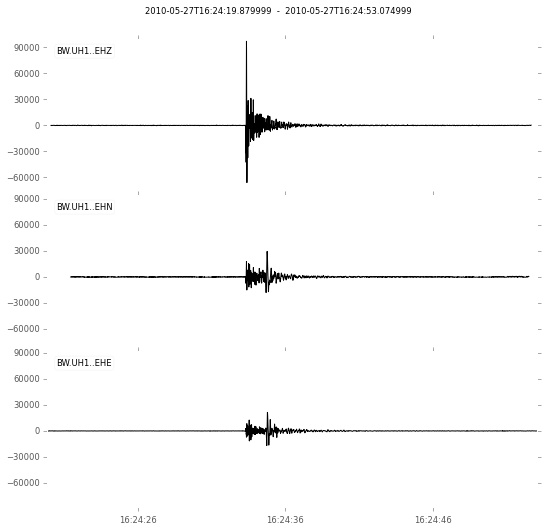

In [22]:
t = event.origins[0].time
client_lmu = Client("http://erde.geophysik.uni-muenchen.de")
stream = client_lmu.get_waveforms(network="BW", station="UH1", location="", channel="EH*",
                                  starttime=t-10, endtime=t+20)
stream.plot()

d) Download station metadata for this station including the instrument response information (using the same client). Attach the response information to the waveforms and remove the instrument response from the waveforms. Plot the waveforms again (now in ground velocity in m/s).

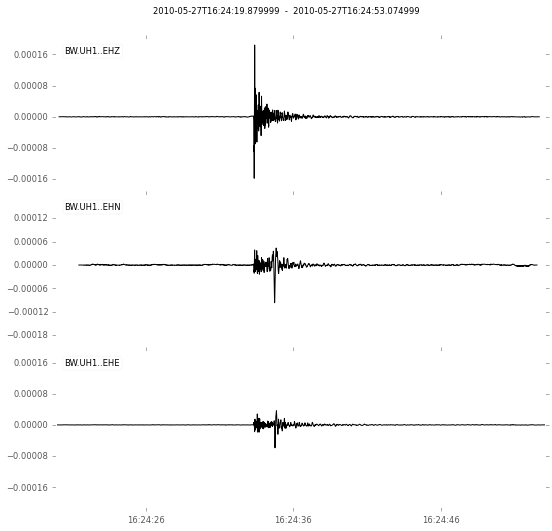

In [23]:
inventory = client_lmu.get_stations(network="BW", station="UH1", level="response")
stream.attach_response(inventory)
stream.remove_response(water_level=10, output="VEL")
stream.plot()

e) The peak ground velocity (PGV) is an important measure to judge possible effects on buildings. Determine the maximum value (absolute, whether positive or negative!) of either of the two horizontal components' data arrays ("N", "E"). You can use Python's builtin "`max()`" and "`abs()`" functions. For your information, ground shaking (in the frequency ranges of these very close earthquakes) can become perceptible to humans at above 0.5-1 mm/s, damage to buildings can be safely excluded for PGV values not exceeding 3 mm/s.

In [24]:
print(stream)
trace1 = stream[0]
trace2 = stream[1]
pgv1 = max(abs(trace1.data))
pgv2 = max(abs(trace2.data))
pgv = max(pgv1, pgv2)
print("PGV in mm/s:", pgv * 1e3)

3 Trace(s) in Stream:
BW.UH1..EHE | 2010-05-27T16:24:19.879999Z - 2010-05-27T16:24:53.074999Z | 200.0 Hz, 6640 samples
BW.UH1..EHN | 2010-05-27T16:24:21.455000Z - 2010-05-27T16:24:52.515000Z | 200.0 Hz, 6213 samples
BW.UH1..EHZ | 2010-05-27T16:24:20.115000Z - 2010-05-27T16:24:52.670000Z | 200.0 Hz, 6512 samples
PGV in mm/s: 0.0966650836762
